# Calculate EPS and baseline Metrics

> (Estimated time: 3 minutes)

In this vignette, we show how to use `ExpressionCopilot` model to calculate the **Expression Predictability Score (EPS)** and baseline metrics for a processed spatial transcriptomics dataset.



In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from expression_copilot import ExpressionCopilotModel

We provide a sample data in Google drive. The image embedding via UNI model has been pre-calculated and stored in the `adata.obsm['X_uni']` field.

In [ ]:
url = 'https://drive.google.com/uc?id=10WD9vFgsoMoTt6g3017XxNK_bq8qp3oM'
adata = sc.read('./adata_with_image_emb.h5ad', backup_url=url)
adata

AnnData object with n_obs × n_vars = 5625 × 2292
    obs: 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'in_tissue', 'pxl_row_in_fullres_old', 'pxl_col_in_fullres_old', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'tile_barcode', '__slide', '__source', 'n_genes', '__batch', 'dataset_title', 'id', 'image_filename', 'organ', 'disease_state', 'oncotree_code', 'species', 'patient', 'st_technology', 'data_publication_date', 'license', 'study_link', 'download_page_link1', 'inter_spot_dist', 'spot_diameter', 'spots_under_tissue', 'preservation_method', 'nb_genes', 'treatment_comment', 'pixel_size_um_embedded', 'pixel_size_um_estimated', 'magnification', 'fullres_px_width', 'fullres_px_height', 'tissue', 'disease_comment', 'subseries', 'hest_v

In [3]:
model = ExpressionCopilotModel(adata, 'X_uni')

2025-09-16 10:43:01.606 | INFO     | expression_copilot.model:__init__:32 - Omics key not provide, will use PCA embedding


We can calculate the EPS and SPS for each gene conveniently.

In [ ]:
eps = model.calc_metrics_per_gene()

2025-09-16 10:43:07.124 | INFO     | expression_copilot.model:calc_metrics_per_gene:68 - Gene metrics: 
              EPS
ALDH1A1  0.052036
CD24     0.053928
PDK4     0.065093


In [5]:
eps.head()

,EPS
ALDH1A1,0.052036
CD24,0.053928
PDK4,0.065093
HIPK2,0.065711
SCG2,0.067656


In [6]:
sps = eps.mean().values
print(f"Spatial predictability score (SPS): {sps[0]:.4f}")

Spatial predictability score (SPS): 0.7392


Then we train a baseline model and calculate its prediction metrics. Here, we use the 'mlp', you can also try 'linear', 'ridge' or 'ensemble' baseline.

In [7]:
baseline_metrics_per_gene, _ = model.calc_baseline_metrics(method = 'mlp')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/flash/grp/gglab/xiacr/NicheAtlas/conda/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /flash/grp/gglab/xiacr/NicheAtlas/conda/lib/python3. ...
/flash/grp/gglab/xiacr/NicheAtlas/conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
2025-09-16 10:43:39.027 | INFO     | expression_copilot.model:calc_baseline_metrics:100 - Baseline: mlp gene metrics: 
pearson_corr     0.406948
spearman

In [8]:
baseline_metrics_per_gene.head()

,pearson_corr,spearman_corr,pearson_pval,spearman_pval,rmse
CD24,0.958017,0.589279,0.0,3.853614e-106,0.350227
ALDH1A1,0.950936,0.404305,0.0,1.751883e-45,0.401168
HIPK2,0.950521,0.508661,0.0,4.558448e-75,0.374933
PDK4,0.949574,0.452058,0.0,9.404741e-58,0.371628
SCG2,0.947840,0.527033,0.0,2.004998e-81,0.378092


At last, we visualize the relationship between EPS and per-gene prediction performance (Pearson correlation) of each gene. And found EPS can reflect the predictability of gene expression well.

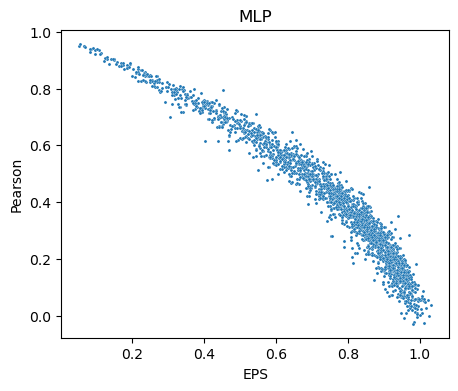

In [9]:
plt.figure(figsize=(5,4))
ax = sns.scatterplot(x=eps['EPS'], y=baseline_metrics_per_gene['pearson_corr'], s=5)
ax.set_ylabel('Pearson')
ax.set_xlabel('EPS')
ax.set_title('MLP')
plt.show()